#### Step-by-Step Transfer Learning with PyTorch

We'll use ResNet18 (you can also try ResNet50 or EfficientNet later).

#### 1. Setup & Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

#### 2. Configuration

In [16]:
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 50
LEARNING_RATE = 0.0001
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)


#### 3. Transforms & Data Loaders

Make sure image size matches pretrained model expectations: 224x224


In [3]:
train_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ColorJitter(0.2,0.2,0.2),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],
                       [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],
                       [0.229,0.224,0.225])
])

In [4]:
train_dataset = datasets.ImageFolder("./dataset/train", transform=train_transform)

val_dataset = datasets.ImageFolder("./dataset/val", transform=test_transform)
test_dataset = datasets.ImageFolder("./dataset/test", transform=test_transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### 4. Load Pretrained Model (ResNet18)

#### Load Pretrained EfficientNet-B0 + Adjust Final Layer

In [6]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [7]:
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Freeze all layers if you're only fine-tuning classifier
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head (last layer)
num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_features, 4)  # 4 classes


#### Update Transforms (Use EfficientNet weights normalization)

In [8]:
transform = weights.transforms()  # includes Resize, ToTensor, Normalize

#### Training/Inference Device

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### 5. Loss, Optimizer, Scheduler

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#### 6. Training Loop

In [27]:
def train(model, train_loader, val_loader, epochs):
    train_acc, val_acc = [], []
    
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc.append(100 * correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")
    
    return train_acc, val_acc

train_acc, val_acc = train(model, train_loader, val_loader, EPOCHS)


Epoch 1/50, Train Acc: 64.80%, Val Acc: 57.95%
Epoch 2/50, Train Acc: 64.03%, Val Acc: 60.23%
Epoch 3/50, Train Acc: 64.03%, Val Acc: 60.23%
Epoch 4/50, Train Acc: 64.29%, Val Acc: 59.09%
Epoch 5/50, Train Acc: 63.52%, Val Acc: 59.09%
Epoch 6/50, Train Acc: 64.54%, Val Acc: 57.95%
Epoch 7/50, Train Acc: 63.78%, Val Acc: 57.95%
Epoch 8/50, Train Acc: 64.03%, Val Acc: 60.23%
Epoch 9/50, Train Acc: 63.27%, Val Acc: 59.09%
Epoch 10/50, Train Acc: 61.73%, Val Acc: 59.09%
Epoch 11/50, Train Acc: 62.24%, Val Acc: 56.82%
Epoch 12/50, Train Acc: 65.31%, Val Acc: 60.23%
Epoch 13/50, Train Acc: 63.78%, Val Acc: 60.23%
Epoch 14/50, Train Acc: 62.76%, Val Acc: 57.95%
Epoch 15/50, Train Acc: 65.82%, Val Acc: 61.36%
Epoch 16/50, Train Acc: 63.27%, Val Acc: 61.36%
Epoch 17/50, Train Acc: 64.80%, Val Acc: 57.95%
Epoch 18/50, Train Acc: 63.01%, Val Acc: 60.23%
Epoch 19/50, Train Acc: 62.76%, Val Acc: 55.68%
Epoch 20/50, Train Acc: 67.09%, Val Acc: 57.95%
Epoch 21/50, Train Acc: 65.31%, Val Acc: 57.95%
E

#### 7. Plot Accuracy Curve

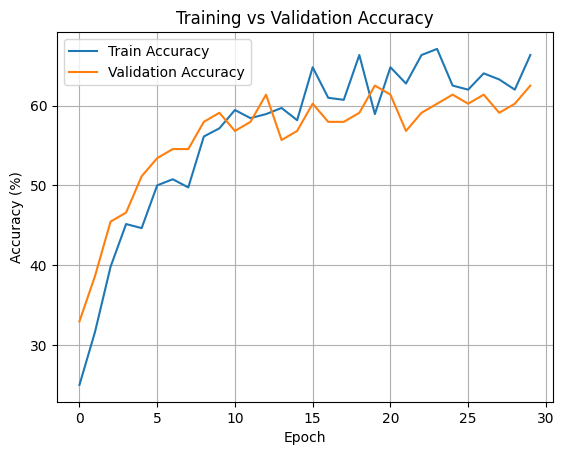

In [12]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### 8. Evaluate on Test Set

In [13]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Test Accuracy: 62.50%


#### 9. Save Model

In [ ]:
torch.save(model.state_dict(), "EfficientNet-B0_car_classifier.pth")

#### 10. Predict New Image

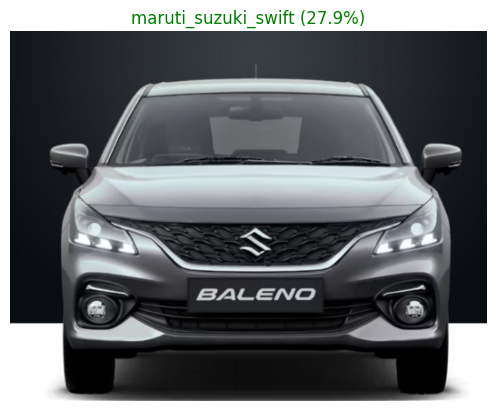

In [28]:
from PIL import Image

# Use same transform
predict_transform = test_transform
class_names = train_dataset.classes

def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    img_tensor = predict_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{class_names[pred.item()]} ({conf.item()*100:.1f}%)", color='green')
    plt.show()

# Example
predict_image("./image_sample/baleno.png")
